<h1><center>Multi-Agent Cooperation using Policy Gradients</center></h1>

## 1. Import Dependencies 

In [1]:
#General Imports
import gym
import json
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import yfinance as yf
from Stock_Trade_Env import StockTradingEnv
import random

#Torch and Baseline Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.distributions import Normal
from torch.autograd import Variable
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv

checkpoint_name = './Checkpoint-Trade'

#Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

## 2. Replay Buffer

In [2]:
class ReplayBuffer:
  def __init__(self,capacity): 
    self.capacity = capacity
    self.buffer = []
    self.position = 0

  def push(self,state,action,reward,next_state,done): 
    if len(self.buffer)<self.capacity:
      self.buffer.append(None)
    self.buffer[self.position] = (state,action,reward,next_state,done)
    self.position = (self.position+1)%self.capacity

  def sample(self,batch_size): 
    batch = random.sample(self.buffer,batch_size)
    state,action,reward,next_state,done = map(np.stack, zip(*batch))
    return state,action,reward,next_state,done

  def __len__(self):
    return len(self.buffer)

## 3. Create Env and Pull Data

In [3]:
# ticker_list = ['AAPL','SPOT','FB','GOOGL','MSFT','SPY','NFLX','AMZN','TSLA','KRX','T']
# data = yf.download('SPY MSFT GOOGL FB SPOT AAPL', '2020-01-01', '2020-02-14', interval='2m')
ticker = 'AAPL'
data = yf.download(ticker, '2019-12-25', '2020-02-19', interval='2m')
print(data.shape)
data = data.to_csv('./data.csv')
data = pd.read_csv('./data.csv')

env = DummyVecEnv([lambda: StockTradingEnv(data)])

[*********************100%***********************]  1 of 1 completed
(6024, 6)


K:\Users\Karush Suri\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### 4.1 Manager Network

In [4]:
class ManagerNetwork(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ManagerNetwork, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs)
        return dist, value

### 4.3 Order Network

In [30]:
class OrderNetwork(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(OrderNetwork, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs)
        return probs, dist, value

## 5. Update Rule

In [6]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

## 6. Test Performance

In [41]:
print('Launching Environment...')

num_inputs  = 6*6
num_outputs = 3

#Hyper params:
hidden_size = 2048
lr          = 3e-4
num_steps   = 1

manager_net = ManagerNetwork(num_inputs,num_outputs,hidden_size).to(device)
order_net = OrderNetwork(num_inputs,num_outputs,hidden_size).to(device)
optimizer_manager = optim.Adam(manager_net.parameters())
optimizer_order = optim.Adam(order_net.parameters())

load_model = False  
if load_model==True:
  #Load Actor Policy Net
    manager_checkpoint = torch.load(checkpoint_name+'/manager_net.pth.tar') 
    manager_net.load_state_dict(manager_checkpoint['model_state_dict'])
    optimizer_manager.load_state_dict(manager_checkpoint['optimizer_state_dict'])
  #Load Order Policy Net
    order_checkpoint = torch.load(checkpoint_name+'/order_net.pth.tar') 
    order_net.load_state_dict(order_checkpoint['model_state_dict'])
    optimizer_order.load_state_dict(order_checkpoint['optimizer_state_dict'])

max_frames   = 1
frame_idx    = 0
test_rewards = []

state = env.reset()
state = np.expand_dims(state.ravel(),axis=0)

total_loss = []; manager_loss = []; order_loss = []
manager_act_loss = [];order_act_loss = [];manager_val_loss = [];order_val_loss = []
total_reward = [];profit = [];net_worth = [];total_sales = [];total_cost = [];shares_sold = [];shares_held = [];balance = [];
masks = []

print('Training Started...')
print('-'*100)

while frame_idx < max_frames:

    log_probs_act = [];log_probs_order = []; rewards = [];
    values_act = [];values_order = [];
    entropy_act = 0; entropy_order = 0;
    
    for i in range(num_steps):
        #Sample action from Mnager Network
        state = torch.FloatTensor(state).to(device)
        dist_act, value_act = manager_net(state)
        act = dist_act.sample()
        
        #Sample amount from Order Network based on command from Manager
        state = torch.cat((state,torch.FloatTensor([act for _ in range(1,num_inputs+1)]).unsqueeze(0)),0)
        probs, dist_order, value_order = order_net(state)
        order = max(probs[:,act])
        
        #Execute action and observe next_state and reward
        action = np.array([act.detach().cpu().numpy(), order.detach().cpu().numpy()])
        action = action.T
        print(action.shape)
        next_state, reward, done, _ = env.step(action)
        bal, s_held, s_sold, cost, sales, net, prof = env.render()

        log_prob_act = dist_act.log_prob(act)
        entropy_act += dist_act.entropy().mean()
        log_probs_act.append(log_prob_act)
        values_act.append(value_act)
        log_prob_order = dist_order.log_prob(order)
        entropy_order += dist_order.entropy().mean()
        log_probs_order.append(log_prob_order)
        values_order.append(value_order)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        next_state = np.expand_dims(next_state.ravel(),axis=0)
        state = next_state
        frame_idx += 1
        total_reward.append(reward)
        
        if frame_idx % 10 == 0 and i%1000 == 0:
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            print('Step-', str(frame_idx), '/', str(max_frames), '| Profit-', prof,'| Model Loss-', loss[-1])
            torch.save({'model_state_dict': manager_net.state_dict(), 'optimizer_state_dict': optimizer_manager.state_dict()},checkpoint_name+'/manager_Net.pth.tar') #save PolicyNet
            torch.save({'model_state_dict': order_net.state_dict(), 'optimizer_state_dict': optimizer_order.state_dict()},checkpoint_name+'/order_net.pth.tar') #save PolicyNet

    
    #Sample next action from Manager Network
    next_state = torch.FloatTensor(next_state).to(device)
    next_dist_act, next_value_act = manager_net(next_state)
    next_act = next_dist_act.sample()
    
    #Update for Manager Network
    returns_act = compute_returns(next_value_act, rewards, masks)
    log_probs_act_temp = torch.cat(log_probs_act)
    returns_act   = torch.cat(returns_act).detach()
    values_act    = torch.cat(values_act)
    advantage_act = returns_act - values_act
    actor_loss  = -(log_probs_act_temp * advantage_act.detach()).mean()
    critic_loss = advantage_act.pow(2).mean()
    loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy_act
    optimizer_manager.zero_grad()
    loss.backward()
    optimizer_manager.step()
    manager_act_loss.append(actor_loss)
    manager_val_loss.append(critic_loss)
    manager_loss.append(loss)
    
    #Sample next action from Order Network
    next_state = torch.cat((next_state,torch.FloatTensor([next_act for _ in range(1,num_inputs+1)]).unsqueeze(0)),0)
    probs,_,next_value_order = order_net(next_state)
    
    #Update for Order Network
    returns_order = compute_returns(next_value_order, rewards, masks)
    log_probs_order_temp = torch.cat(log_probs_order)
    returns_order   = torch.cat(returns_order).detach()
    values_order    = torch.cat(values_order)
    advantage_order = returns_order - values_order
    actor_loss  = -(log_probs_order_temp * advantage_order.detach()).mean()
    critic_loss = advantage_order.pow(2).mean()
    loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy_order
    optimizer_order.zero_grad()
    loss.backward()
    optimizer_order.step()
    order_act_loss.append(actor_loss)
    order_val_loss.append(critic_loss)
    order_loss.append(loss)
    
    #Log data
    balance.append(bal),profit.append(prof),shares_held.append(s_held),shares_sold.append(s_sold),total_cost.append(cost)
    total_sales.append(sales),net_worth.append(net)

    
    total_loss.append(manager_loss[-1] + order_loss[-1])

    

Launching Environment...
Training Started...
----------------------------------------------------------------------------------------------------
(1, 2)
1.0 0.3191261291503906


## 8. Save Model and Data

In [46]:
data_save = {}
data_save['loss'] = total_loss
data_save['manager_loss'] = manager_loss
data_save['order_loss'] = order_loss
data_save['manager_act_loss'] = manager_act_loss
data_save['order_act_loss'] = order_act_loss
data_save['manager_val_loss'] = manager_val_loss
data_save['order_val_loss'] = order_val_loss
data_save['reward'] = total_reward
data_save['profit'] = profit
data_save['net_worth'] = net_worth
data_save['total_sales'] = total_sales
data_save['cost_basis'] = cost_basis
data_save['shares_sold'] = shares_sold
data_save['shares_held'] = shares_held
data_save['balance'] = balance

with open(checkpoint_name+'/data_save.pkl', 'wb') as f: #data+same as frame folder
    pickle.dump(data_save, f)

## 9. Plot Results

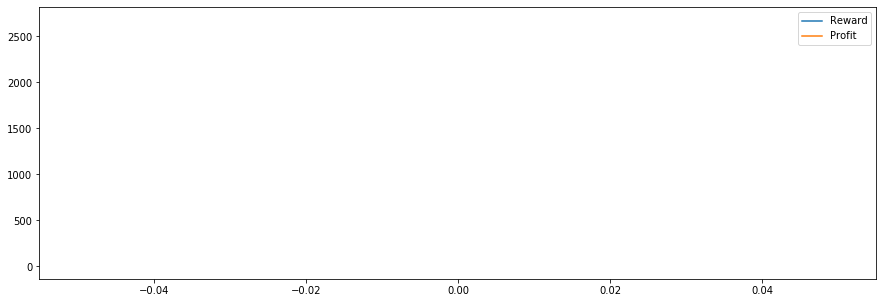

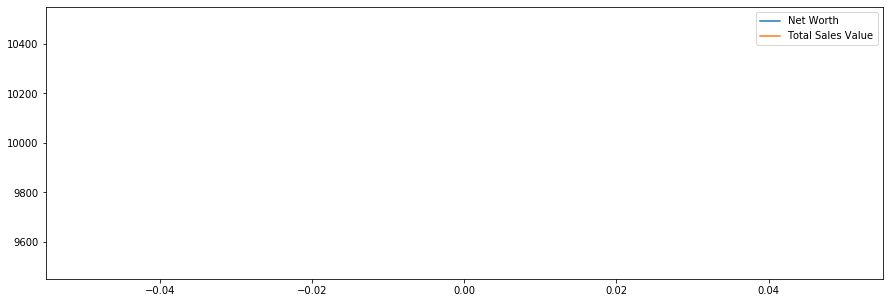

NameError: name 'total_shares_sold' is not defined

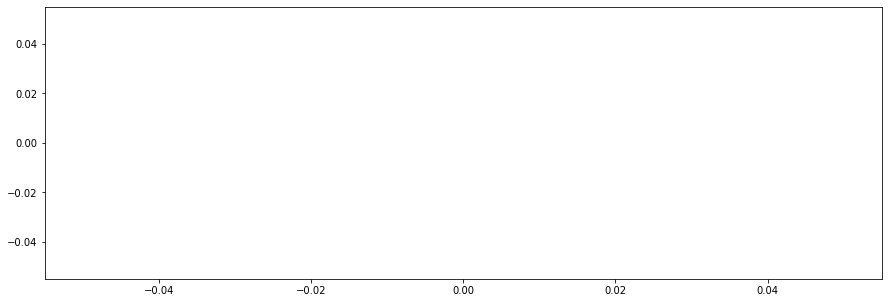

In [47]:
#Plot reward and profit
plt.figure(figsize=(15,5))
plt.plot(reward)
plt.plot(profit)
plt.legend(['Reward','Profit'])
plt.show()

#Plot net worth and total sales value
plt.figure(figsize=(15,5))
plt.plot(net_worth)
plt.plot(total_sales_value)
plt.legend(['Net Worth','Total Sales Value'])
plt.show()

#Plot Shares
plt.figure(figsize=(15,5))
plt.plot(shares_held)
plt.plot(total_shares_sold)
plt.legend(['Shares Held','Shares Sold'])
plt.show()

#Plot cost-basis and balance
plt.figure(figsize=(15,5))
plt.plot(cost_basis)
plt.plot(balance)
plt.legend(['Cost Basis','Balance'])
plt.show()